In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor


plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

In [2]:
base_df = pd.read_csv('modelling_base_data.csv')

In [3]:
base_df.head()

,Unnamed: 0,pickup_hour,cnt,zip_code,description,is_weekend,weekday,hour,weeknum,month,day
0,0,2015-01-01 00:00:00,835,25,15,0,3,0,1,1,1
1,1,2015-01-01 00:00:00,37,253,15,0,3,0,1,1,1
2,2,2015-01-01 00:00:00,1367,16,15,0,3,0,1,1,1
3,3,2015-01-01 00:00:00,3,290,15,0,3,0,1,1,1
4,4,2015-01-01 00:00:00,54,67,15,0,3,0,1,1,1


In [4]:
def split_train_and_test(df, date):
    """
    Split to train and test data based on given date
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

In [5]:
train_df, test_df = split_train_and_test(base_df, '2015-09-31')

In [6]:
train_df.drop(columns=['Unnamed: 0', 'pickup_hour'],axis=1,inplace=True)
test_df.drop(columns=['Unnamed: 0', 'pickup_hour'],axis=1,inplace=True)

/Users/sangdonlee/opt/anaconda3/envs/bigquery/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
train_df.head()

,cnt,zip_code,description,is_weekend,weekday,hour,weeknum,month,day
0,835,25,15,0,3,0,1,1,1
1,37,253,15,0,3,0,1,1,1
2,1367,16,15,0,3,0,1,1,1
3,3,290,15,0,3,0,1,1,1
4,54,67,15,0,3,0,1,1,1


In [8]:
train_df.tail()

,cnt,zip_code,description,is_weekend,weekday,hour,weeknum,month,day
785776,951,12,12,0,2,23,40,9,30
785777,342,39,12,0,2,23,40,9,30
785778,9,66,12,0,2,23,40,9,30
785779,18,253,12,0,2,23,40,9,30
785780,15,62,12,0,2,23,40,9,30


In [9]:
def evaluation(model, y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([model, mae, mse], index=['model', 'mae', 'mse'], columns=['score']).T
    return score

In [10]:
target_col = 'cnt'
feature_cols = ['zip_code', 'description', 'is_weekend', 'weekday', 'hour', 'day']

In [11]:
print(feature_cols)

['zip_code', 'description', 'is_weekend', 'weekday', 'hour', 'day']


In [12]:
X_train = train_df[feature_cols]
X_test = test_df[feature_cols]
y_train = train_df[target_col]
y_test = test_df[target_col]

In [13]:
max_depth=5
learning_rate=0.1
n_estimators=100
n_jobs=-1
num_leaves=31


xgb_reg = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, n_jobs=n_jobs)
lgm_reg = LGBMRegressor(num_leaves=num_leaves, max_depth=-1, learning_rate=learning_rate, n_estimators=n_estimators)
rf_reg = RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)

In [14]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
lgm_reg.fit(X_train, y_train)

LGBMRegressor()

In [16]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [17]:
xgb_pred = xgb_reg.predict(X_test)

In [18]:
lgm_pred = lgm_reg.predict(X_test)

In [19]:
rf_pred = rf_reg.predict(X_test)

In [20]:
xgb_eva = evaluation('XGBRegressor', y_test, xgb_pred)
xgb_eva

,model,mae,mse
score,XGBRegressor,38.0938,6013.17


In [21]:
lgm_eva = evaluation('LGBMRegressor', y_test, lgm_pred)
lgm_eva

,model,mae,mse
score,LGBMRegressor,32.3182,4936.81


In [22]:
rf_eva = evaluation('RFR', y_test, rf_pred)
rf_eva

,model,mae,mse
score,RFR,24.6811,5069.85


In [23]:
frames = [xgb_eva, lgm_eva, rf_eva]
evaluation_agg = pd.concat(frames)

<AxesSubplot:title={'center':'Model MSE Comparison'}, xlabel='model'>

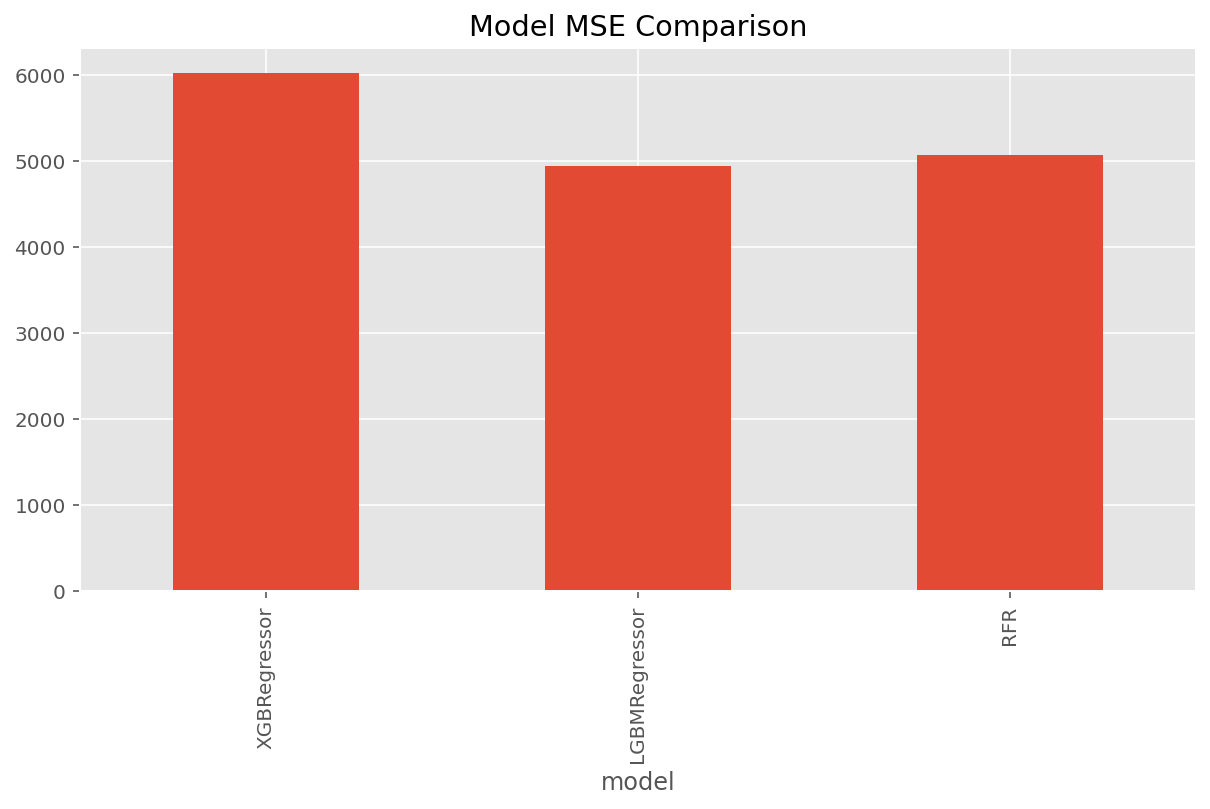

In [24]:
evaluation_agg.set_index('model')['mse'].plot(kind='bar', title='Model MSE Comparison', figsize=(10,5))

<AxesSubplot:title={'center':'XGBR Feature Importance'}>

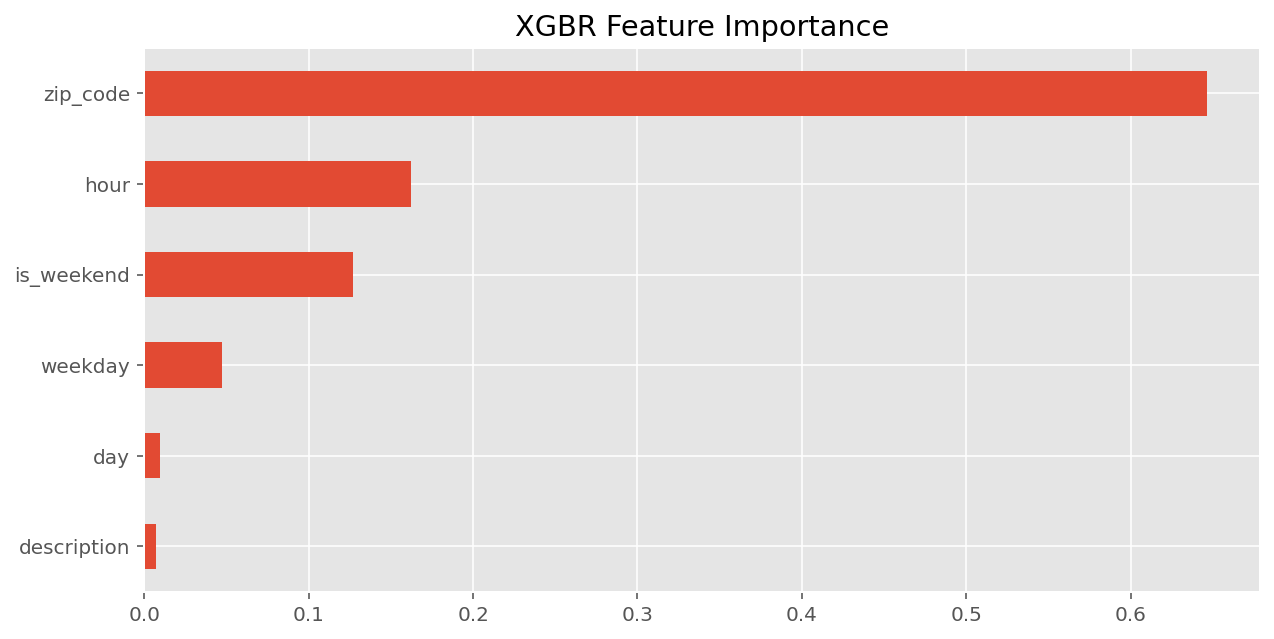

In [25]:
feat_importances = pd.Series(xgb_reg.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(8).plot(kind='barh', title='XGBR Feature Importance', figsize=(10,5))

<AxesSubplot:title={'center':'LGBMR Feature Importance'}>

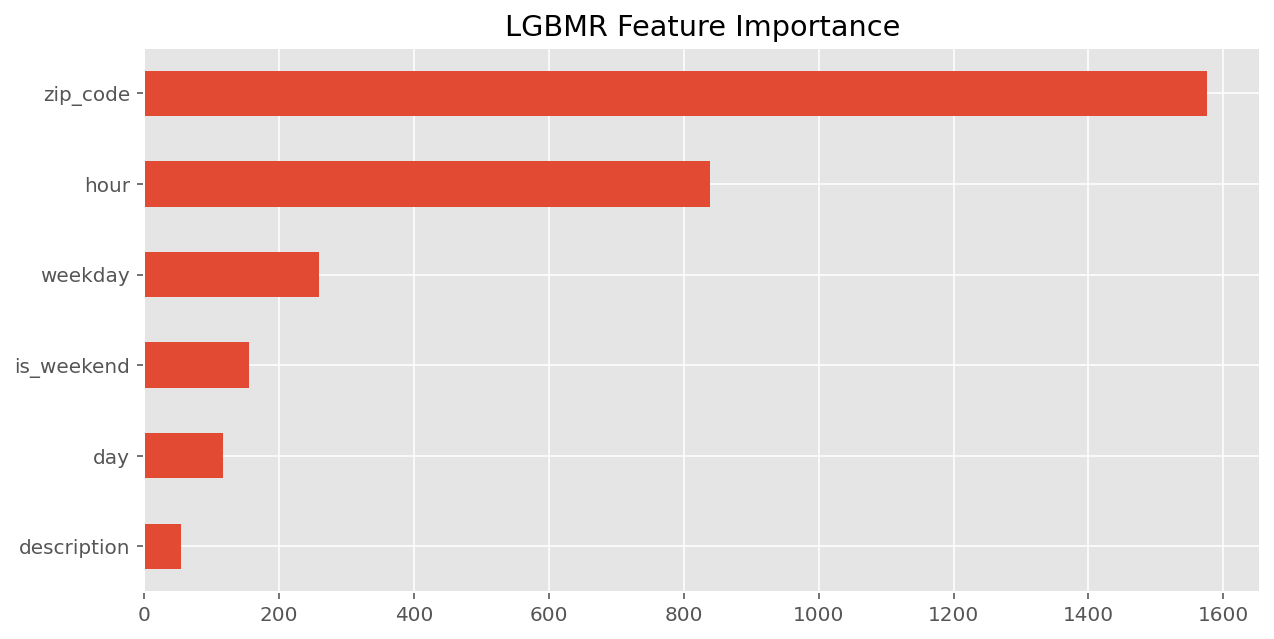

In [26]:
feat_importances_lgbm = pd.Series(lgm_reg.feature_importances_, index=X_train.columns)
feat_importances_lgbm.nsmallest(8).plot(kind='barh', title='LGBMR Feature Importance', figsize=(10,5))

<AxesSubplot:title={'center':'RFR Feature Importance'}>

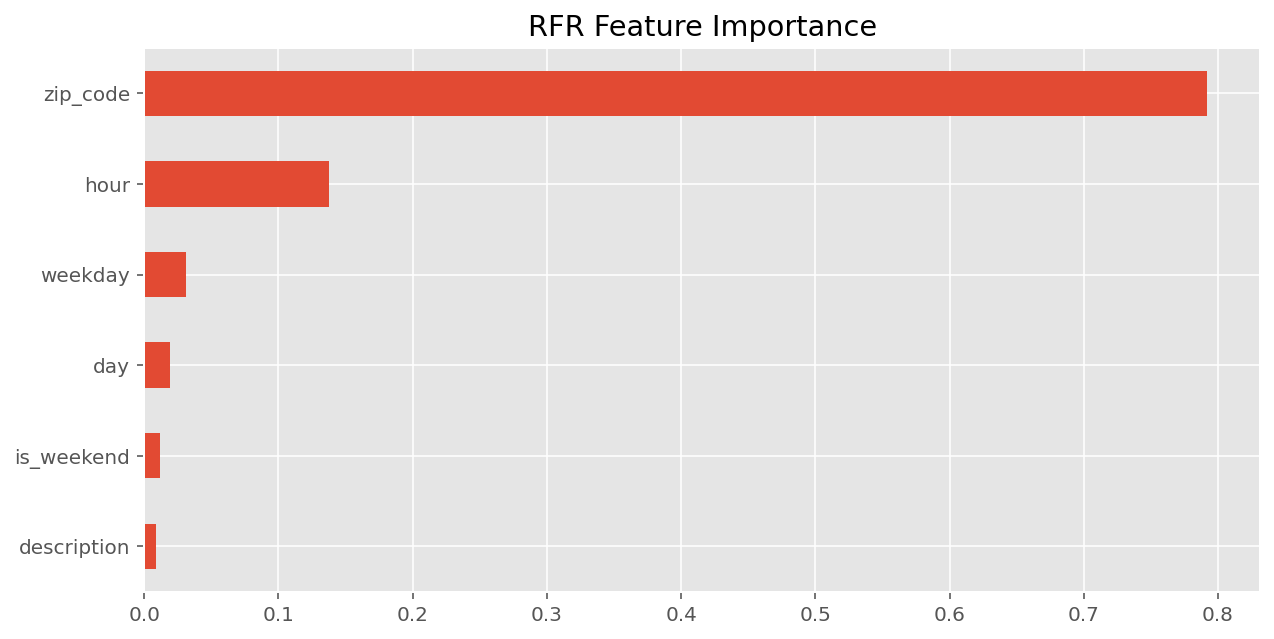

In [27]:
feat_importances_rf = pd.Series(rf_reg.feature_importances_, index=X_train.columns)
feat_importances_rf.nsmallest(8).plot(kind='barh', title='RFR Feature Importance', figsize=(10,5))

In [28]:
test_df['y_true'] = y_test
test_df['y_pred'] = lgm_pred
test_df['year'] = 2015
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])

/Users/sangdonlee/opt/anaconda3/envs/bigquery/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sangdonlee/opt/anaconda3/envs/bigquery/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sangdonlee/opt/anaconda3/envs/bigquery/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [29]:
test_df.head()

,cnt,zip_code,description,is_weekend,weekday,hour,weeknum,month,day,y_true,y_pred,year,datetime
785781,199,248,12,0,3,0,40,10,1,199,98.260794,2015,2015-10-01
785782,177,18,12,0,3,0,40,10,1,177,373.363686,2015,2015-10-01
785783,6,54,12,0,3,0,40,10,1,6,27.330211,2015,2015-10-01
785784,648,0,12,0,3,0,40,10,1,648,690.371352,2015,2015-10-01
785785,1,94,12,0,3,0,40,10,1,1,21.216993,2015,2015-10-01


In [30]:
test_df.tail()

,cnt,zip_code,description,is_weekend,weekday,hour,weeknum,month,day,y_true,y_pred,year,datetime
1046725,11,268,11,0,3,23,53,12,31,11,9.502454,2015,2015-12-31 23:00:00
1046726,2,240,11,0,3,23,53,12,31,2,15.721661,2015,2015-12-31 23:00:00
1046727,649,12,11,0,3,23,53,12,31,649,1024.211441,2015,2015-12-31 23:00:00
1046728,1,64,11,0,3,23,53,12,31,1,15.547039,2015,2015-12-31 23:00:00
1046729,234,41,11,0,3,23,53,12,31,234,278.020319,2015,2015-12-31 23:00:00


In [31]:
test_df_oct = test_df[test_df['month'] == 10]
test_df_nov = test_df[test_df['month'] == 11]
test_df_dec = test_df[test_df['month'] == 12]

In [32]:
test_df_oct.groupby('datetime').sum()[['y_true', 'y_pred']]

,y_true,y_pred
datetime,,
2015-10-01 00:00:00,12210,16307.545710
2015-10-01 01:00:00,7385,11583.632747
2015-10-01 02:00:00,4631,9054.645609
2015-10-01 03:00:00,2948,5912.185219
2015-10-01 04:00:00,2827,5833.110545
...,...,...
2015-10-31 19:00:00,23774,24536.321766
2015-10-31 20:00:00,22251,24018.243842
2015-10-31 21:00:00,22421,24045.074896


In [184]:
test_df_oct[test_df_oct['datetime'] < '2015-10-08'].head(100)

,cnt,zip_code,description,is_weekend,weekday,hour,weeknum,month,day,y_true,y_pred,year,datetime
785781,199,248,12,0,3,0,40,10,1,199,98.260794,2015,2015-10-01
785782,177,18,12,0,3,0,40,10,1,177,373.363686,2015,2015-10-01
785783,6,54,12,0,3,0,40,10,1,6,27.330211,2015,2015-10-01
785784,648,0,12,0,3,0,40,10,1,648,690.371352,2015,2015-10-01
785785,1,94,12,0,3,0,40,10,1,1,21.216993,2015,2015-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
785876,574,1,12,0,3,0,40,10,1,574,601.328644,2015,2015-10-01
785877,21,53,12,0,3,0,40,10,1,21,27.330211,2015,2015-10-01
785878,41,35,12,0,3,0,40,10,1,41,58.600213,2015,2015-10-01
785879,893,16,12,0,3,0,40,10,1,893,914.079612,2015,2015-10-01


<AxesSubplot:title={'center':'NYC Taxi Demand 2015-10 Prediction'}, xlabel='datetime'>

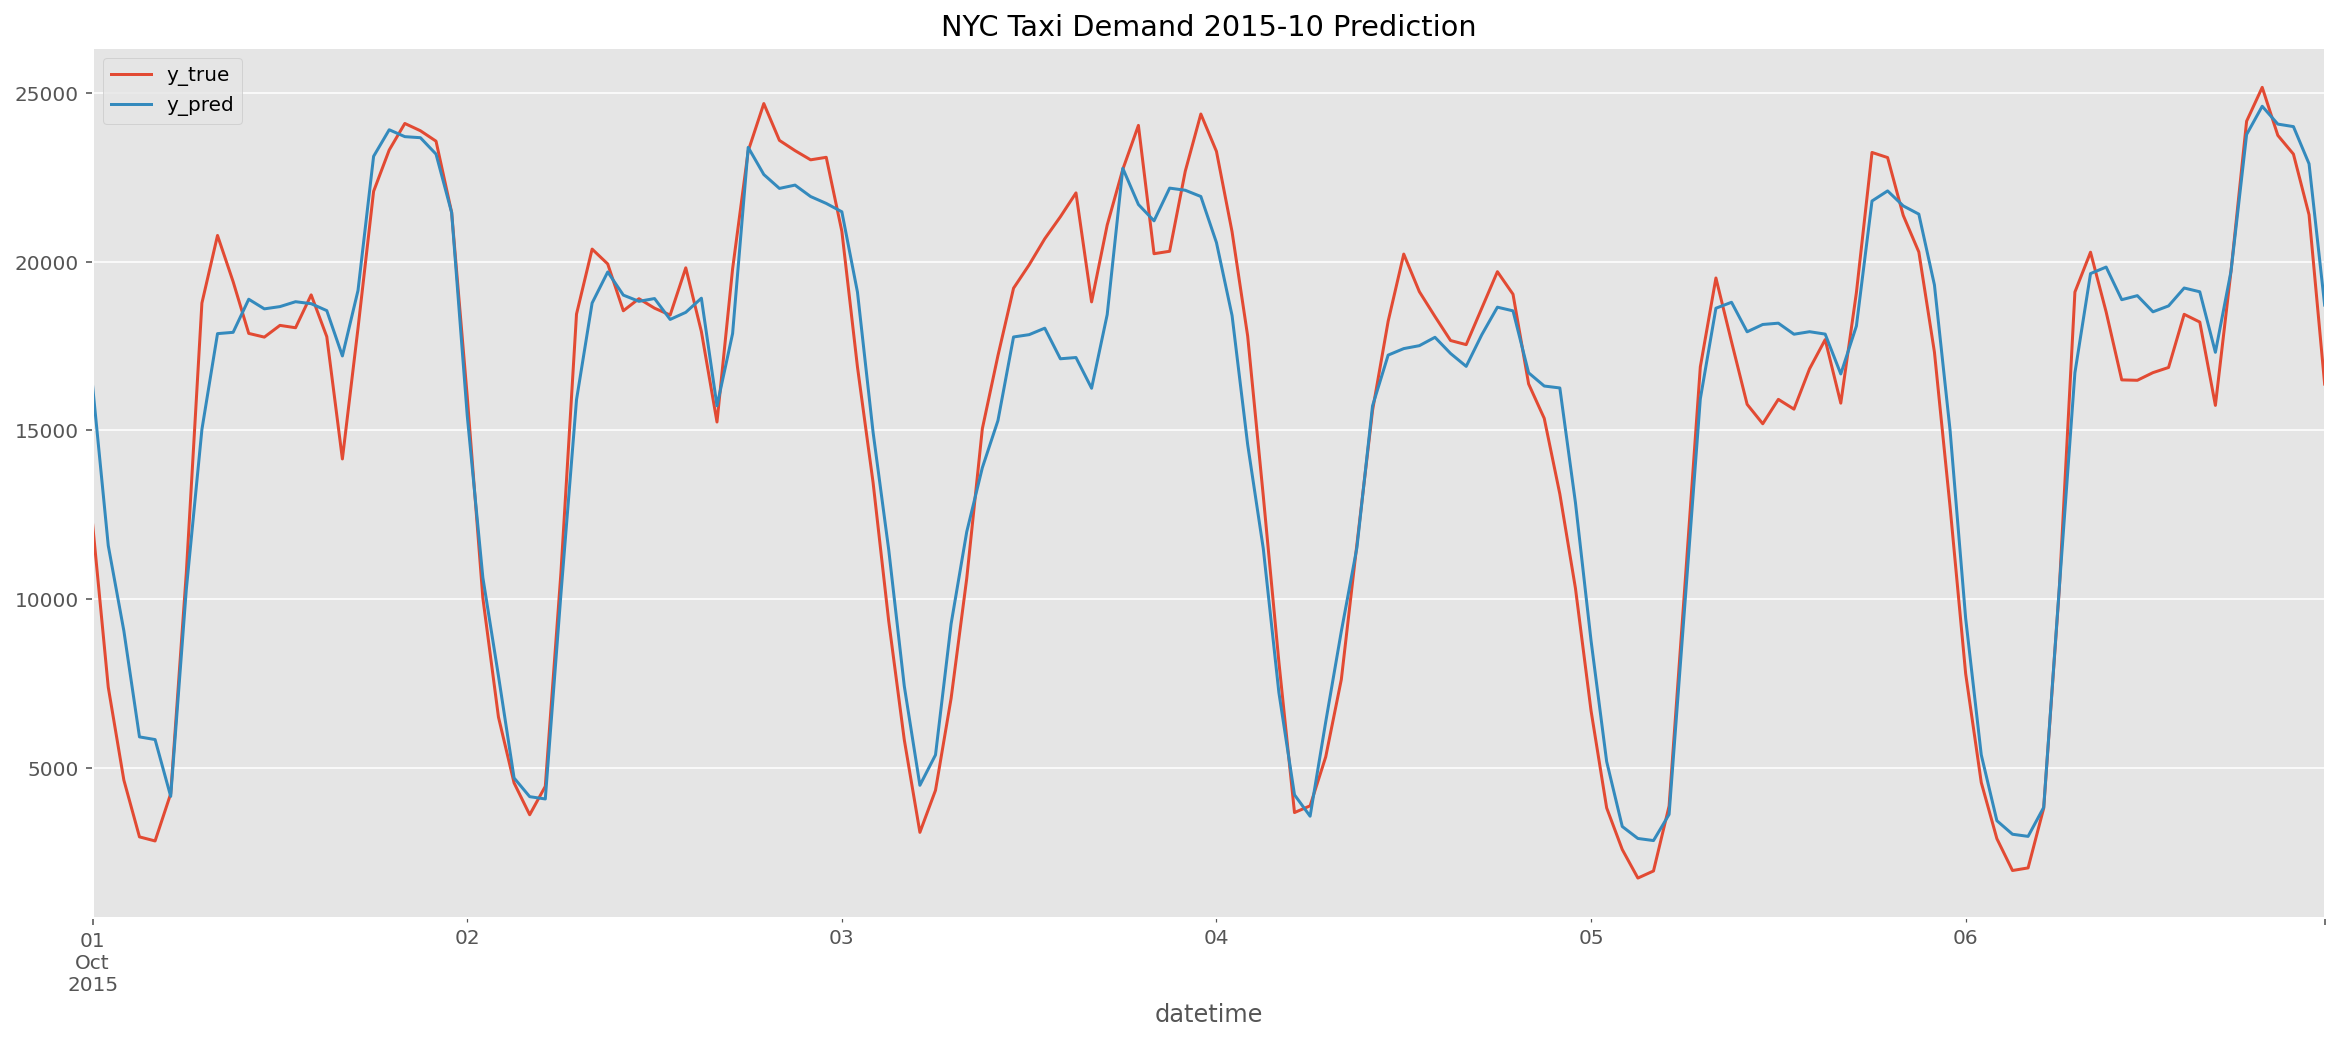

In [189]:

test_df_oct[test_df_oct['datetime'] < '2015-10-07'].groupby('datetime').sum()[['y_true', 'y_pred']].plot(figsize=(20,8), title='NYC Taxi Demand 2015-10 Prediction')

<AxesSubplot:title={'center':'NYC Taxi Demand 2015-10 Prediction'}, xlabel='datetime'>

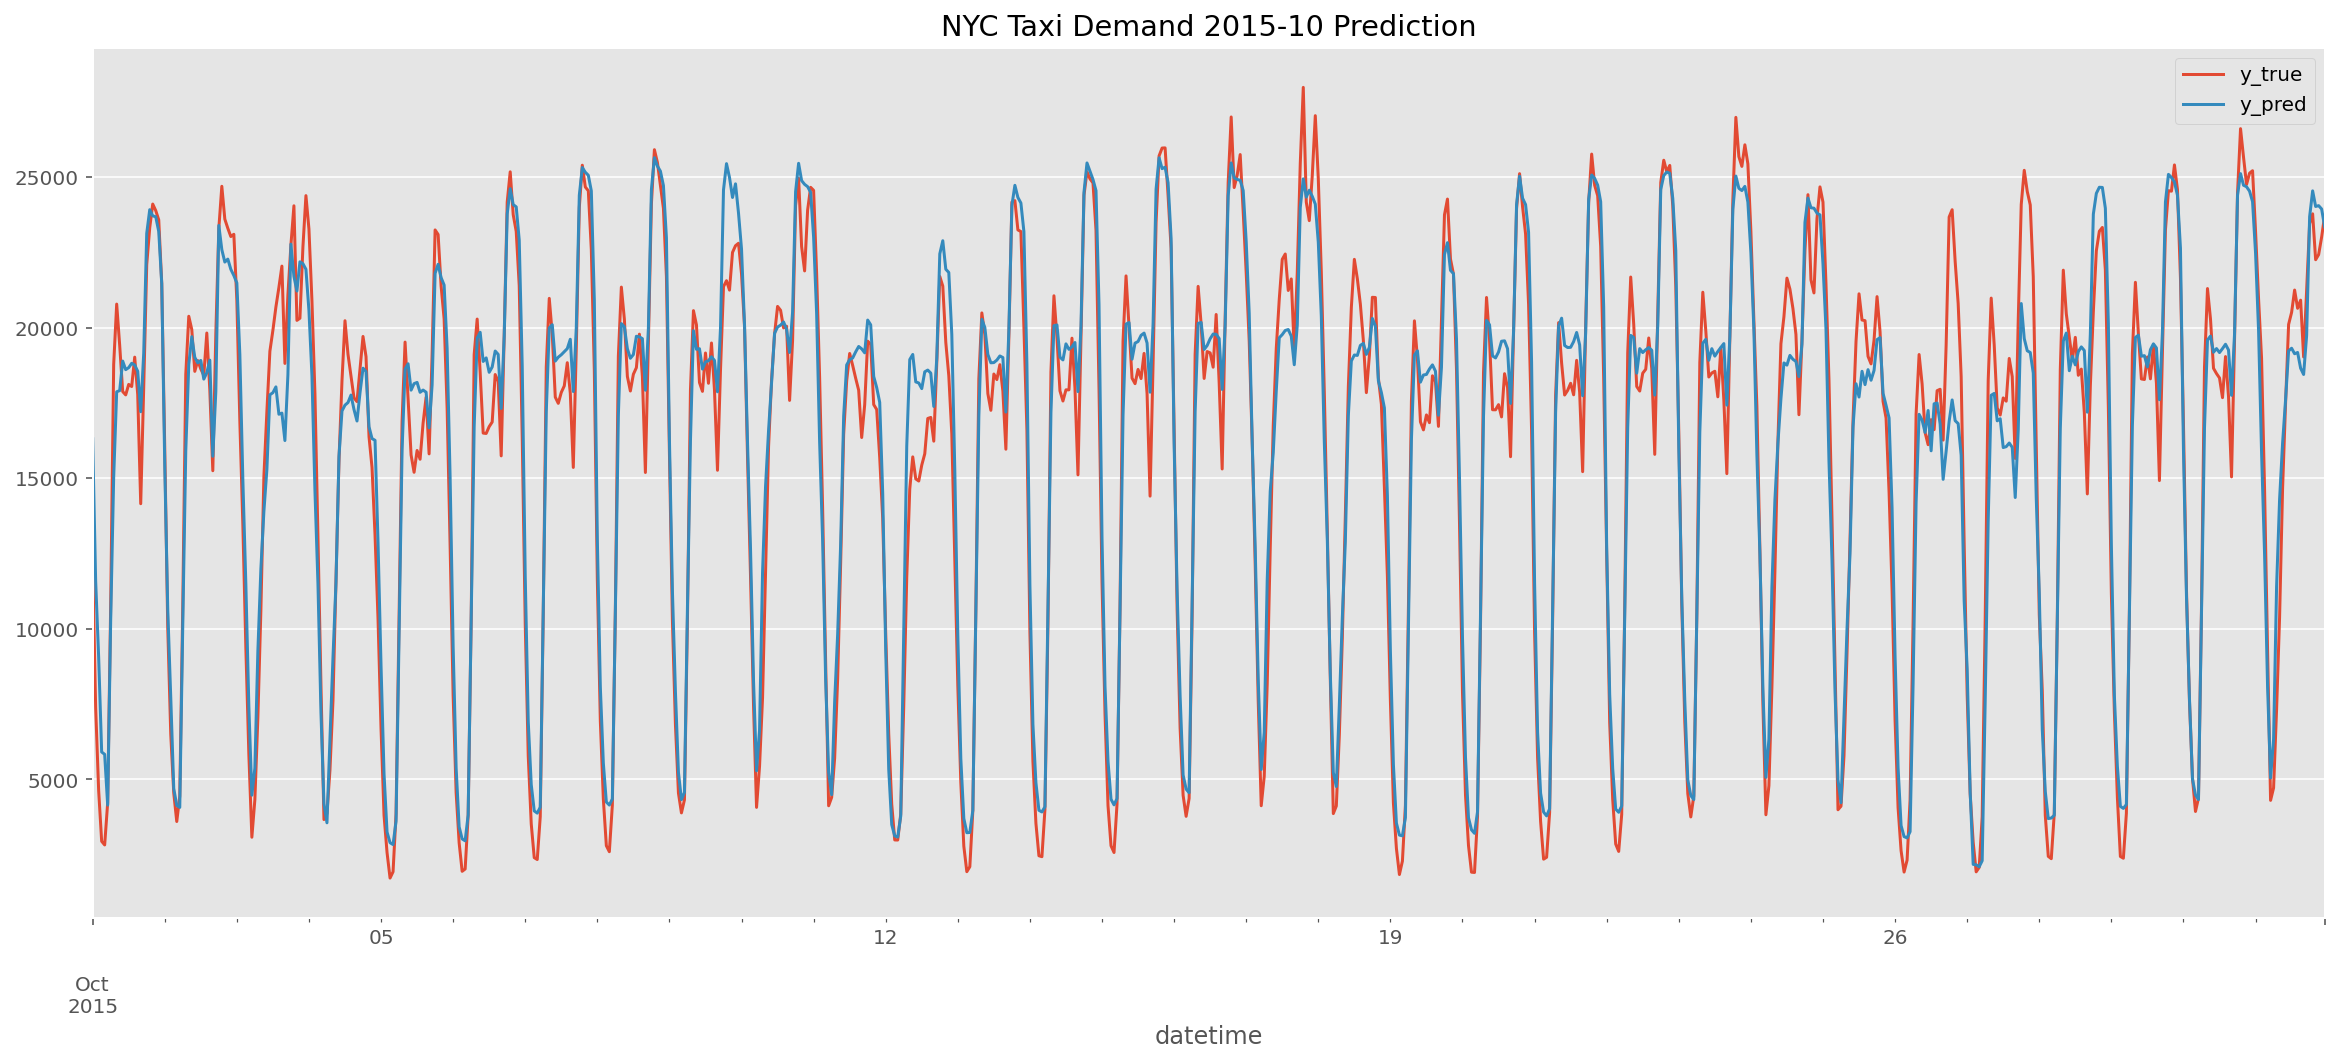

In [186]:
test_df_oct.groupby('datetime').sum()[['y_true', 'y_pred']].plot(figsize=(20,8), title='NYC Taxi Demand 2015-10 Prediction')

<AxesSubplot:title={'center':'NYC Taxi Demand 2015-12 Prediction'}, xlabel='datetime'>

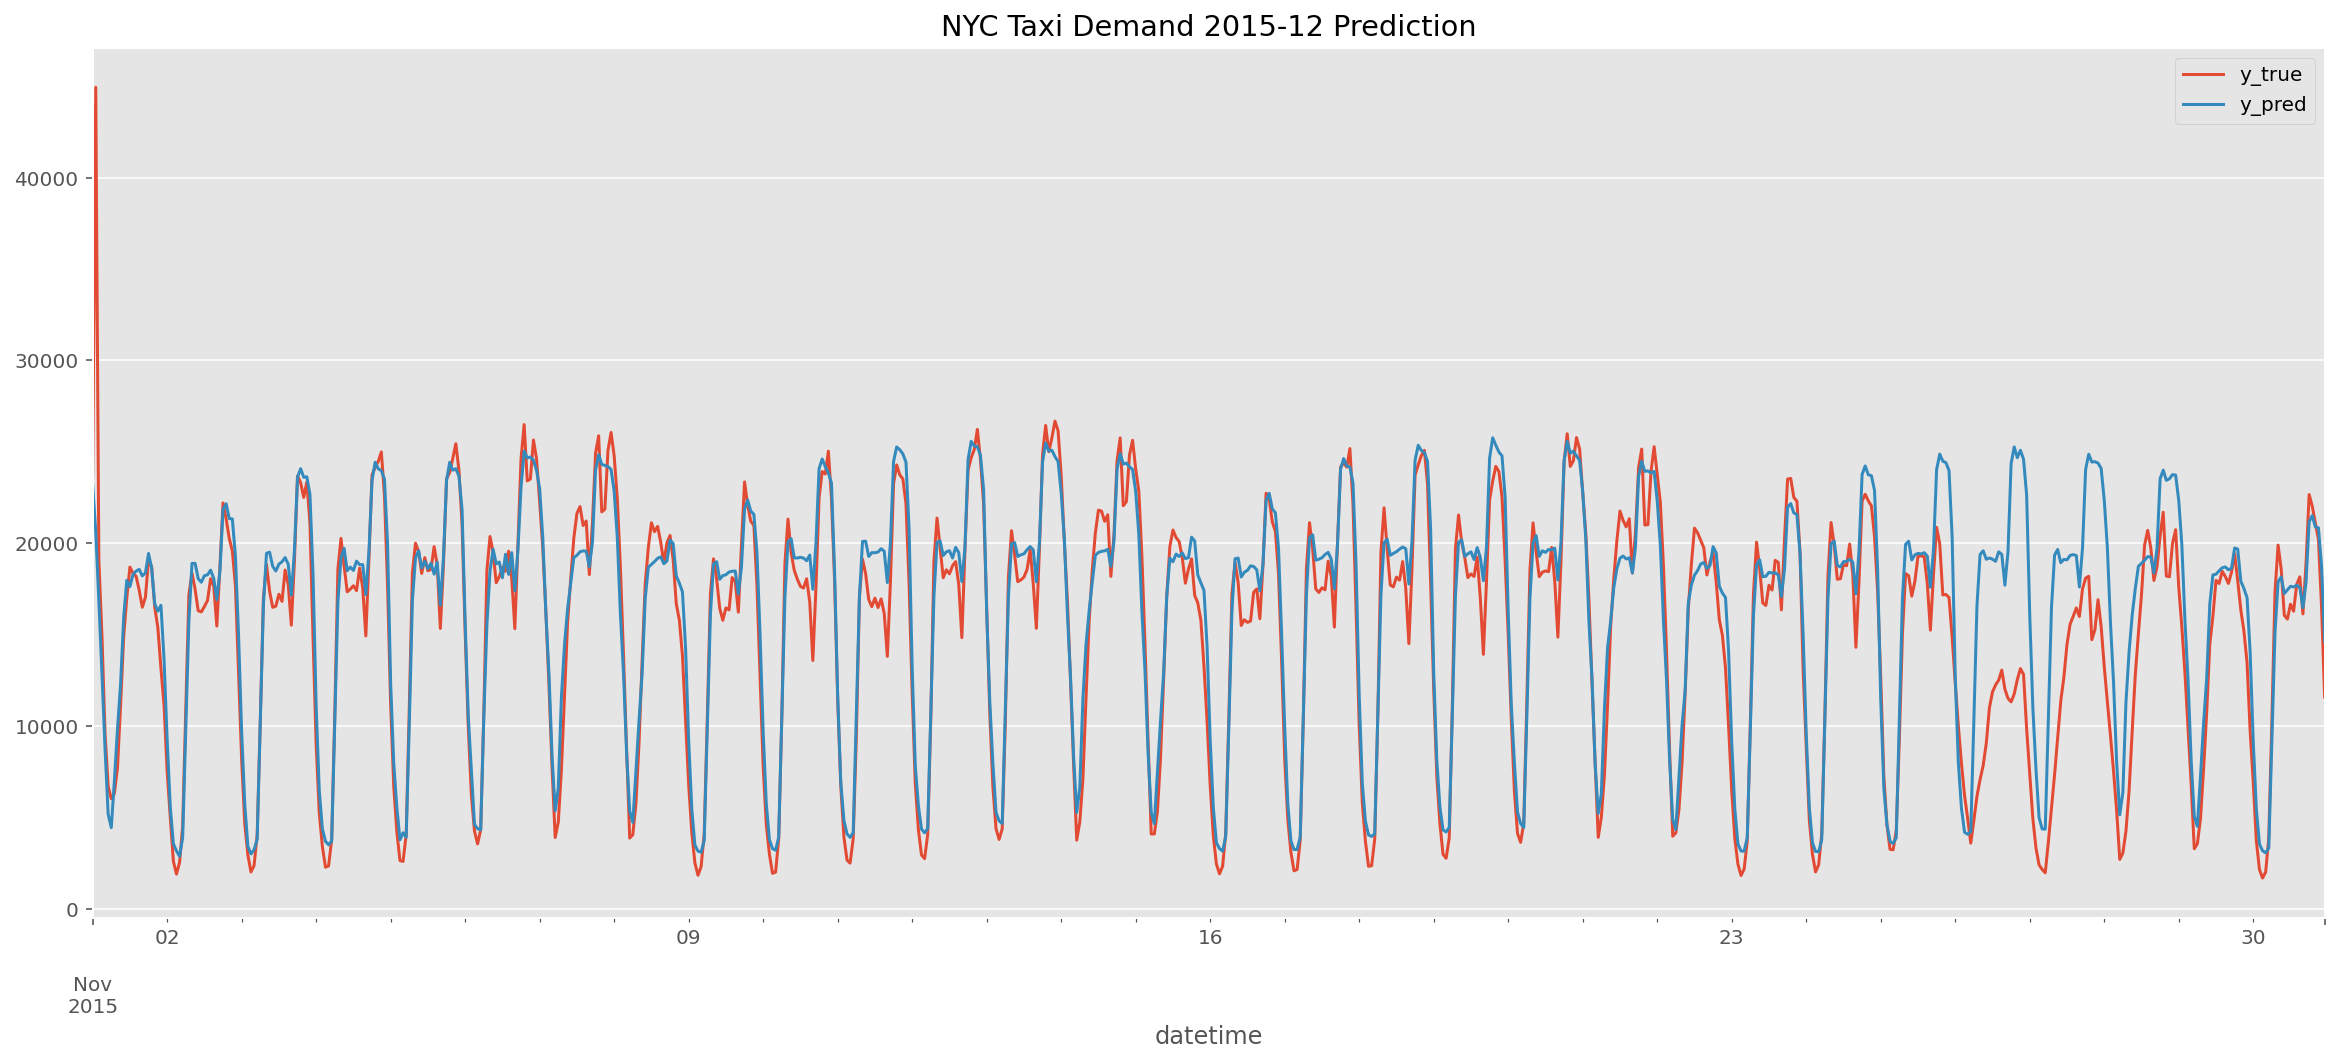

In [37]:
test_df_nov.groupby('datetime').sum()[['y_true', 'y_pred']].plot(figsize=(20,8), title='NYC Taxi Demand 2015-12 Prediction')

<AxesSubplot:title={'center':'NYC Taxi Demand 2015-12 Prediction'}, xlabel='datetime'>

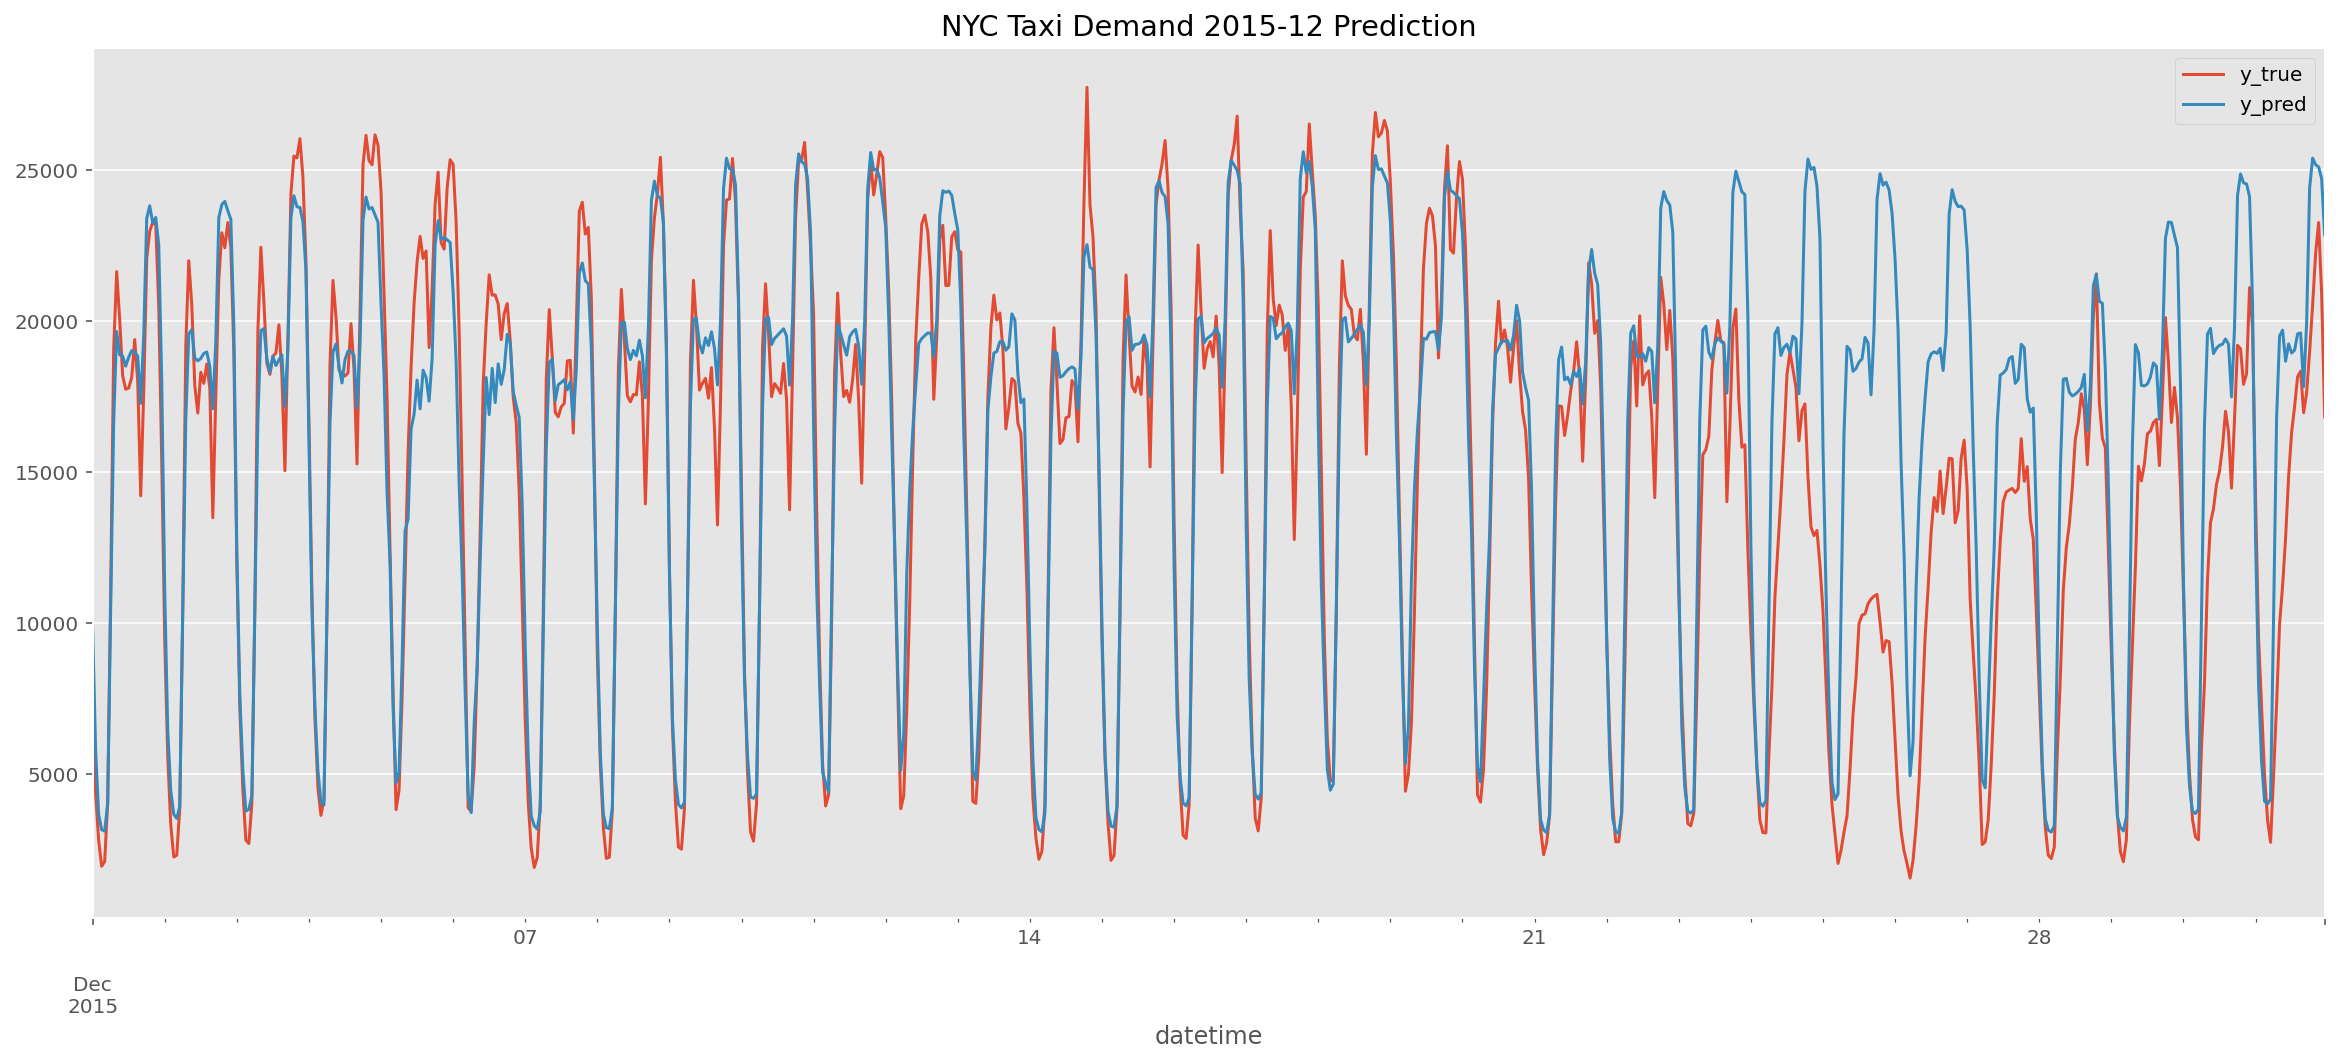

In [38]:
test_df_dec.groupby('datetime').sum()[['y_true', 'y_pred']].plot(figsize=(20,8), title='NYC Taxi Demand 2015-12 Prediction')

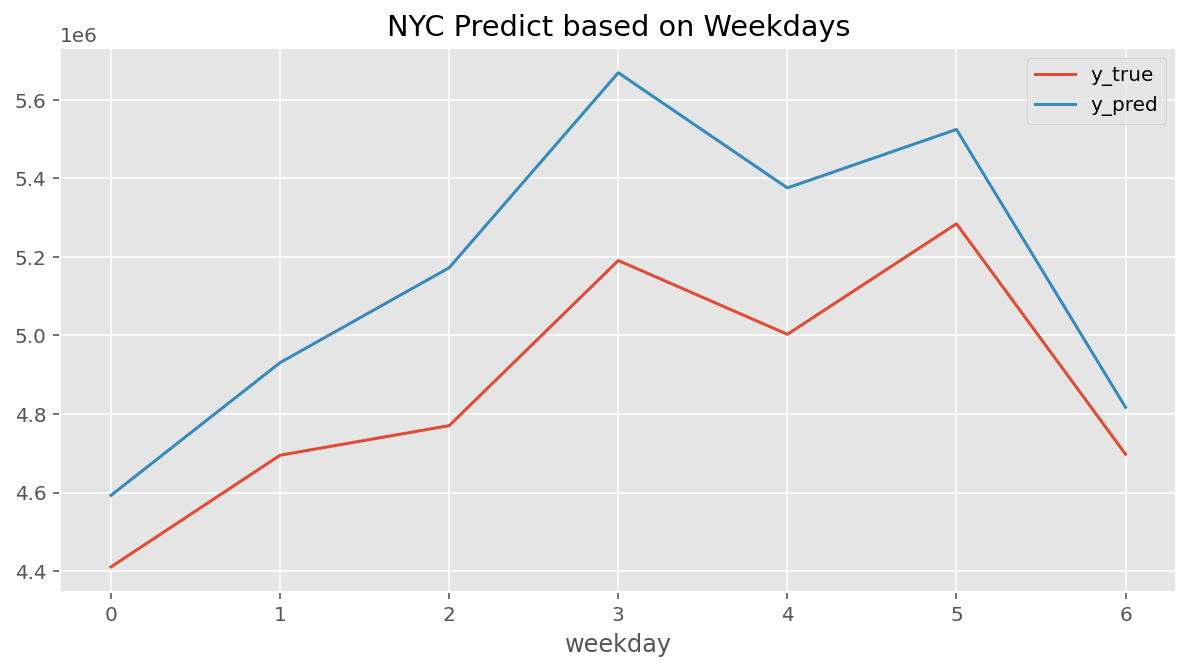

In [35]:
test_df[['weekday','y_true', 'y_pred']].groupby('weekday').sum()[['y_true', 'y_pred']].plot(figsize=(10,5), title='NYC Predict based on Weekdays');

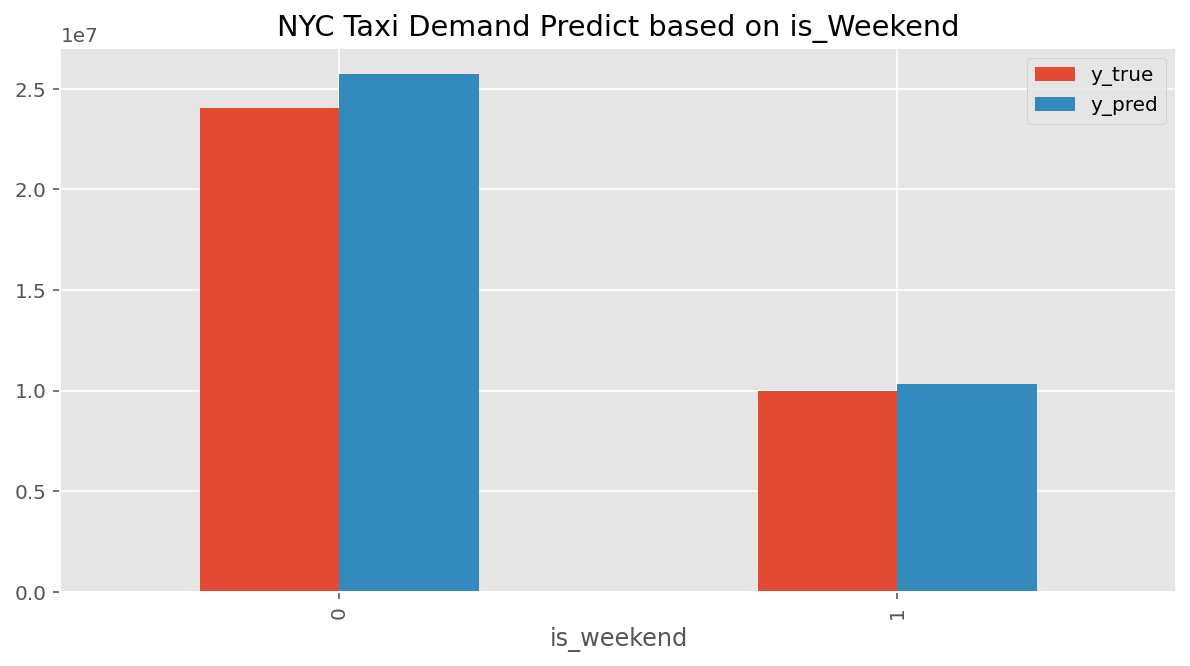

In [36]:
test_df[['is_weekend','y_true', 'y_pred']].groupby('is_weekend').sum()[['y_true', 'y_pred']].plot(kind='bar', figsize=(10,5), title='NYC Taxi Demand Predict based on is_Weekend');